**Disclaimer** The original version was done using GPU accelerated simulation. CPU usage has been added but the model training might be both slower and not as good at the end. GPU is recommended if possible

In [2]:
# for GPU acceleration install jax with CUDA support and numpyro
# pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#pip install numpyro

import pandas as pd
import numpy as np 
import pymc as pm 
import arviz as az
import xarray as xr
from causalgraphicalmodels import CausalGraphicalModel
import jax

device = jax.default_backend()
print(device)

import matplotlib.pyplot as plt
# Load the data
data = pd.read_csv('../data/nyc_regression_data.csv')
data

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


gpu


,precinct,perp_race,perp_sex,age_group,ofns_desc,law_cat_cd
0,1.0,WHITE,M,25-44,CRIMINAL MISCHIEF & RELATED OF,M
1,1.0,BLACK,M,25-44,FELONY ASSAULT,F
2,1.0,WHITE HISPANIC,M,45-64,CRIMINAL TRESPASS,M
3,1.0,BLACK,M,45-64,ASSAULT 3 & RELATED OFFENSES,M
4,1.0,WHITE,M,45-64,OTHER STATE LAWS,V
...,...,...,...,...,...,...
63610,123.0,WHITE,M,18-24,DANGEROUS WEAPONS,F
63611,123.0,WHITE,M,25-44,ROBBERY,F
63612,123.0,BLACK,F,18-24,FELONY ASSAULT,F
63613,123.0,BLACK,F,45-64,FELONY ASSAULT,F


In [3]:
data_m_f = data[(data["law_cat_cd"].isin(["M", "F"]))]
data_m_f

,precinct,perp_race,perp_sex,age_group,ofns_desc,law_cat_cd
0,1.0,WHITE,M,25-44,CRIMINAL MISCHIEF & RELATED OF,M
1,1.0,BLACK,M,25-44,FELONY ASSAULT,F
2,1.0,WHITE HISPANIC,M,45-64,CRIMINAL TRESPASS,M
3,1.0,BLACK,M,45-64,ASSAULT 3 & RELATED OFFENSES,M
5,1.0,WHITE HISPANIC,M,25-44,DANGEROUS DRUGS,M
...,...,...,...,...,...,...
63610,123.0,WHITE,M,18-24,DANGEROUS WEAPONS,F
63611,123.0,WHITE,M,25-44,ROBBERY,F
63612,123.0,BLACK,F,18-24,FELONY ASSAULT,F
63613,123.0,BLACK,F,45-64,FELONY ASSAULT,F


In [4]:
data_m_f["perp_race"] = data_m_f["perp_race"].apply(lambda x: "BLACK" if "BLACK" in x else "NON BLACK")

/tmp/ipykernel_27039/2538464095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_m_f["perp_race"] = data_m_f["perp_race"].apply(lambda x: "BLACK" if "BLACK" in x else "NON BLACK")


## Precinct only model

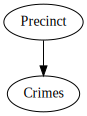

In [5]:
crime_amount = CausalGraphicalModel(
    nodes=["Precinct", "Crimes"],
    edges=[
        ("Precinct", "Crimes"), 
    ]
)

crime_amount.draw()

In [6]:
data_grouped = data_m_f.groupby(["precinct"])[["perp_race", "perp_sex"]].value_counts().reset_index(name="count")
data_grouped

,precinct,perp_race,perp_sex,count
0,1.0,NON BLACK,M,344
1,1.0,BLACK,M,327
2,1.0,BLACK,F,65
3,1.0,NON BLACK,F,65
4,5.0,BLACK,M,327
...,...,...,...,...
303,122.0,BLACK,F,23
304,123.0,NON BLACK,M,216
305,123.0,BLACK,M,44
306,123.0,NON BLACK,F,39


In [7]:
X = data_grouped.drop(columns=["count"])
y = data_grouped["count"]

In [8]:
X_enc = pd.get_dummies(X, columns=["precinct", "perp_race", "perp_sex"], dtype=float)


### Drop variables is not done as each label needs to be modelled as a distribution separately
# X_enc = X_enc.drop(columns=["perp_race_NON BLACK","perp_sex_F"])

<Axes: >

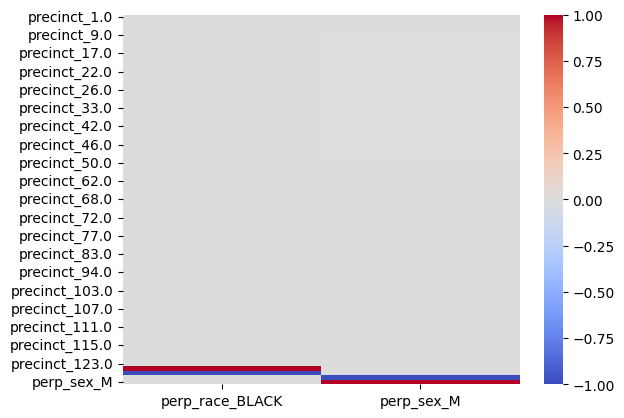

In [11]:
import seaborn as sns

corr_matrix = X_enc.corr()

sns.heatmap(corr_matrix.iloc[:,[-4,-1]], vmin=-1, vmax=1, cmap="coolwarm")

In [12]:
with pm.Model() as precinct_count_model_2:
    beta = pm.Normal('beta', mu=0, sigma=1.5, shape=len(X_enc.columns) - 4)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(pm.math.dot(X_enc.iloc[:,:-4], beta)))
    
    crime = pm.Poisson('crime', lambda_, observed=y)

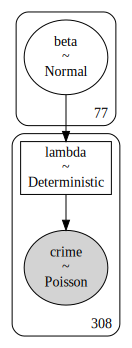

In [13]:
pm.model_to_graphviz(precinct_count_model_2)

In [15]:
with precinct_count_model_2:
    if device == "gpu":    
        precinct_count_trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs=dict(log_likelihood=True), cores=4,nuts_sampler="numpyro")
    else:
        precinct_count_trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs=dict(log_likelihood=True))


/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 2000/2000 [00:35<00:00, 56.84it/s, 7 steps of size 4.32e-01. acc. prob=0.89]  


In [16]:
az.summary(precinct_count_trace, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],5.295,0.036,5.227,5.364,0.000,0.000,5966.0,2713.0,1.00
beta[1],5.228,0.037,5.164,5.302,0.000,0.000,5658.0,2736.0,1.00
beta[2],4.881,0.044,4.797,4.961,0.001,0.000,5984.0,2824.0,1.00
beta[3],4.984,0.042,4.899,5.059,0.001,0.000,5913.0,2930.0,1.00
beta[4],4.826,0.045,4.748,4.913,0.001,0.000,5942.0,2786.0,1.01
...,...,...,...,...,...,...,...,...,...
beta[72],5.741,0.028,5.690,5.797,0.000,0.000,5810.0,3201.0,1.00
beta[73],5.838,0.027,5.787,5.892,0.000,0.000,5924.0,2694.0,1.00
beta[74],5.280,0.036,5.209,5.343,0.000,0.000,6010.0,2760.0,1.00
beta[75],4.603,0.050,4.503,4.695,0.001,0.001,4736.0,2531.0,1.00


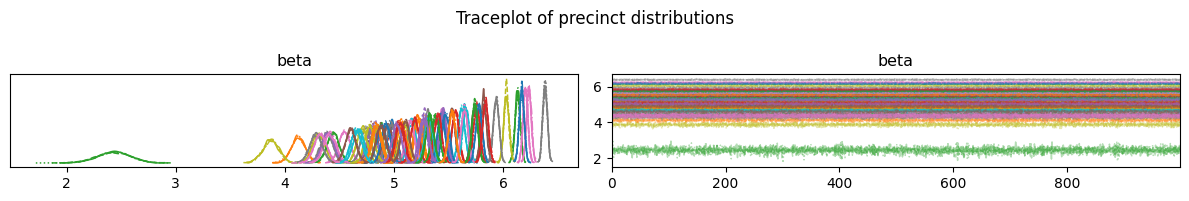

In [17]:
az.plot_trace(precinct_count_trace, var_names=["beta"])
plt.suptitle("Traceplot of precinct distributions")
plt.tight_layout()

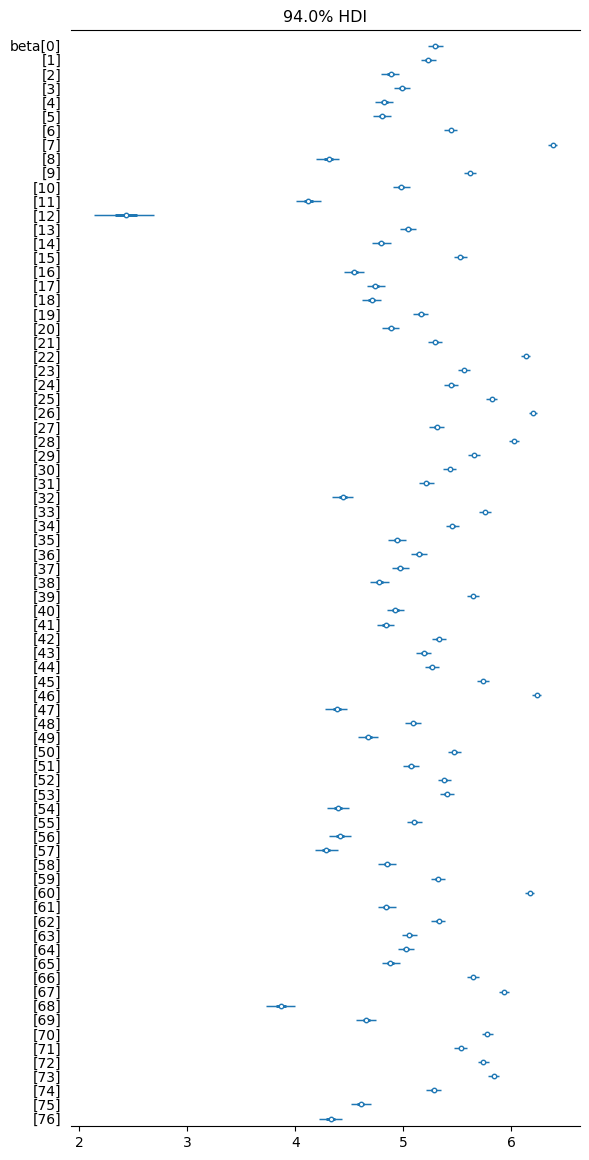

In [101]:
az.plot_forest(precinct_count_trace, combined=True, var_names=["beta"], textsize=10)

plt.tight_layout()

## Precinct and Sex

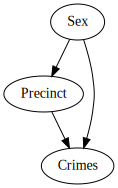

In [18]:
crime_amount = CausalGraphicalModel(
    nodes=["Precinct", "Crimes", "Sex"],
    edges=[
        ("Precinct", "Crimes"), 
        ("Sex", "Precinct"),
        ("Sex", "Crimes")
    ]
)

crime_amount.draw()

In [20]:
with pm.Model() as precinct_sex_count_model:
    beta = pm.Normal('beta', mu=0, sigma=1.5, shape=len(X_enc.columns) - 4)
    gamma = pm.Normal('gamma', mu=5, sigma=1.5, shape=2)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(pm.math.dot(X_enc.iloc[:,:-4], beta) 
                                                     + pm.math.dot(X_enc.iloc[:,-2:], gamma)))
    
    crime = pm.Poisson('crime', lambda_, observed=y)

In [21]:
with precinct_sex_count_model:
    prior_checks = pm.sample_prior_predictive(samples=100)

Sampling: [beta, crime, gamma]


In [22]:
with precinct_sex_count_model:
    if device == "gpu":    
        precinct_sex_count_trace = pm.sample(2000, tune=2000, return_inferencedata=True, cores=4, idata_kwargs=dict(log_likelihood=True), nuts_sampler="numpyro")
    else:
        precinct_sex_count_trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs=dict(log_likelihood=True))

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4000/4000 [01:25<00:00, 46.57it/s, 31 steps of size 2.59e-02. acc. prob=0.93] 
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
az.summary(precinct_sex_count_trace, var_names=["beta", "gamma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.068,0.144,-0.210,0.336,0.039,0.028,14.0,28.0,1.20
beta[1],0.002,0.144,-0.296,0.256,0.039,0.028,14.0,28.0,1.20
beta[2],-0.345,0.146,-0.619,-0.064,0.039,0.028,15.0,27.0,1.19
beta[3],-0.243,0.145,-0.522,0.039,0.039,0.028,14.0,28.0,1.20
beta[4],-0.401,0.147,-0.690,-0.133,0.039,0.028,15.0,28.0,1.19
...,...,...,...,...,...,...,...,...,...
beta[74],0.053,0.144,-0.224,0.329,0.039,0.028,14.0,27.0,1.20
beta[75],-0.622,0.148,-0.923,-0.359,0.039,0.028,15.0,29.0,1.19
beta[76],-0.898,0.150,-1.184,-0.616,0.039,0.028,16.0,30.0,1.17
gamma[0],4.178,0.140,3.923,4.441,0.039,0.028,14.0,25.0,1.21


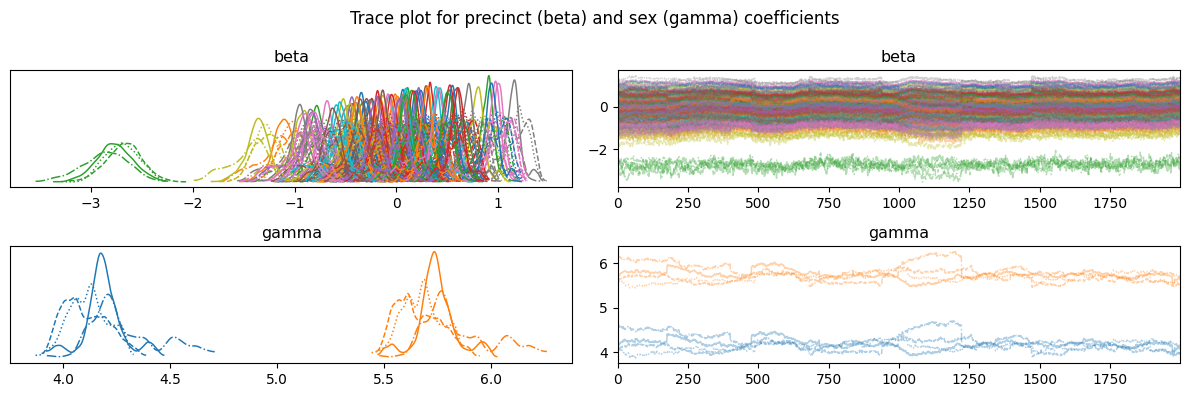

In [24]:
az.plot_trace(precinct_sex_count_trace, var_names=["beta", "gamma"], )
plt.suptitle("Trace plot for precinct (beta) and sex (gamma) coefficients")
plt.tight_layout()

## Precinct and Race

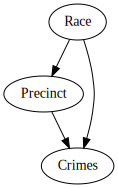

In [26]:
crime_amount = CausalGraphicalModel(
    nodes=["Precinct", "Crimes", "Race"],
    edges=[
        ("Precinct", "Crimes"), 
        ("Race", "Precinct"),
        ("Race", "Crimes")
    ]
)

crime_amount.draw()

In [27]:
with pm.Model() as precinct_race_count_model:
    beta = pm.Normal('beta', mu=0, sigma=1.5, shape=len(X_enc.columns) - 4)
    eta = pm.Normal('eta', mu=5, sigma=10, shape=2)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(pm.math.dot(X_enc.iloc[:,:-4], beta) 
                                                     + pm.math.dot(X_enc.iloc[:,-4:-2], eta)))
    
    crime = pm.Poisson('crime', lambda_, observed=y)

In [28]:
with precinct_race_count_model:
    prior_checks = pm.sample_prior_predictive(samples=100)

Sampling: [beta, crime, eta]


In [29]:
with precinct_race_count_model:
    if device == "gpu": 
        precinct_race_count_trace = pm.sample(2000, tune=2000, return_inferencedata=True, cores=4, idata_kwargs=dict(log_likelihood=True), nuts_sampler="numpyro")
    else:
        precinct_race_count_trace = pm.sample(2000, tune=2000, return_inferencedata=True, idata_kwargs=dict(log_likelihood=True))

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4000/4000 [00:41<00:00, 96.13it/s, 31 steps of size 5.09e-02. acc. prob=0.92]  
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [28]:
az.summary(precinct_race_count_trace, var_names=["beta", "eta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.175,0.222,-0.264,0.588,0.079,0.058,8.0,25.0,1.45
beta[1],0.109,0.222,-0.349,0.504,0.079,0.058,8.0,24.0,1.45
beta[2],-0.238,0.223,-0.711,0.148,0.079,0.058,8.0,25.0,1.44
beta[3],-0.136,0.223,-0.594,0.264,0.079,0.058,8.0,25.0,1.44
beta[4],-0.295,0.224,-0.735,0.121,0.079,0.058,8.0,24.0,1.44
...,...,...,...,...,...,...,...,...,...
beta[74],0.160,0.222,-0.295,0.560,0.079,0.058,8.0,26.0,1.45
beta[75],-0.515,0.225,-0.965,-0.100,0.079,0.058,8.0,25.0,1.43
beta[76],-0.789,0.227,-1.242,-0.372,0.080,0.059,8.0,28.0,1.42
eta[0],5.246,0.219,4.842,5.688,0.079,0.058,8.0,28.0,1.46


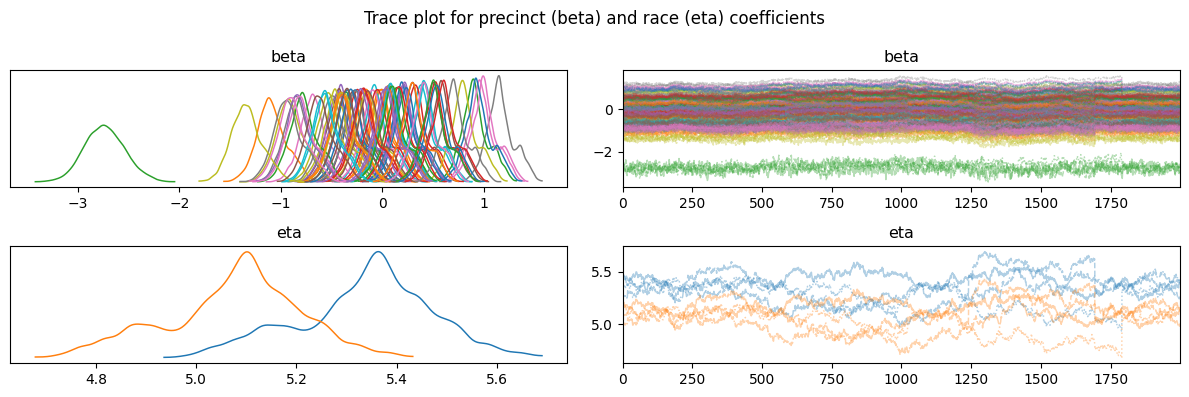

In [30]:
az.plot_trace(precinct_race_count_trace, var_names=["beta", "eta"], combined=True)
plt.suptitle("Trace plot for precinct (beta) and race (eta) coefficients")
plt.tight_layout()

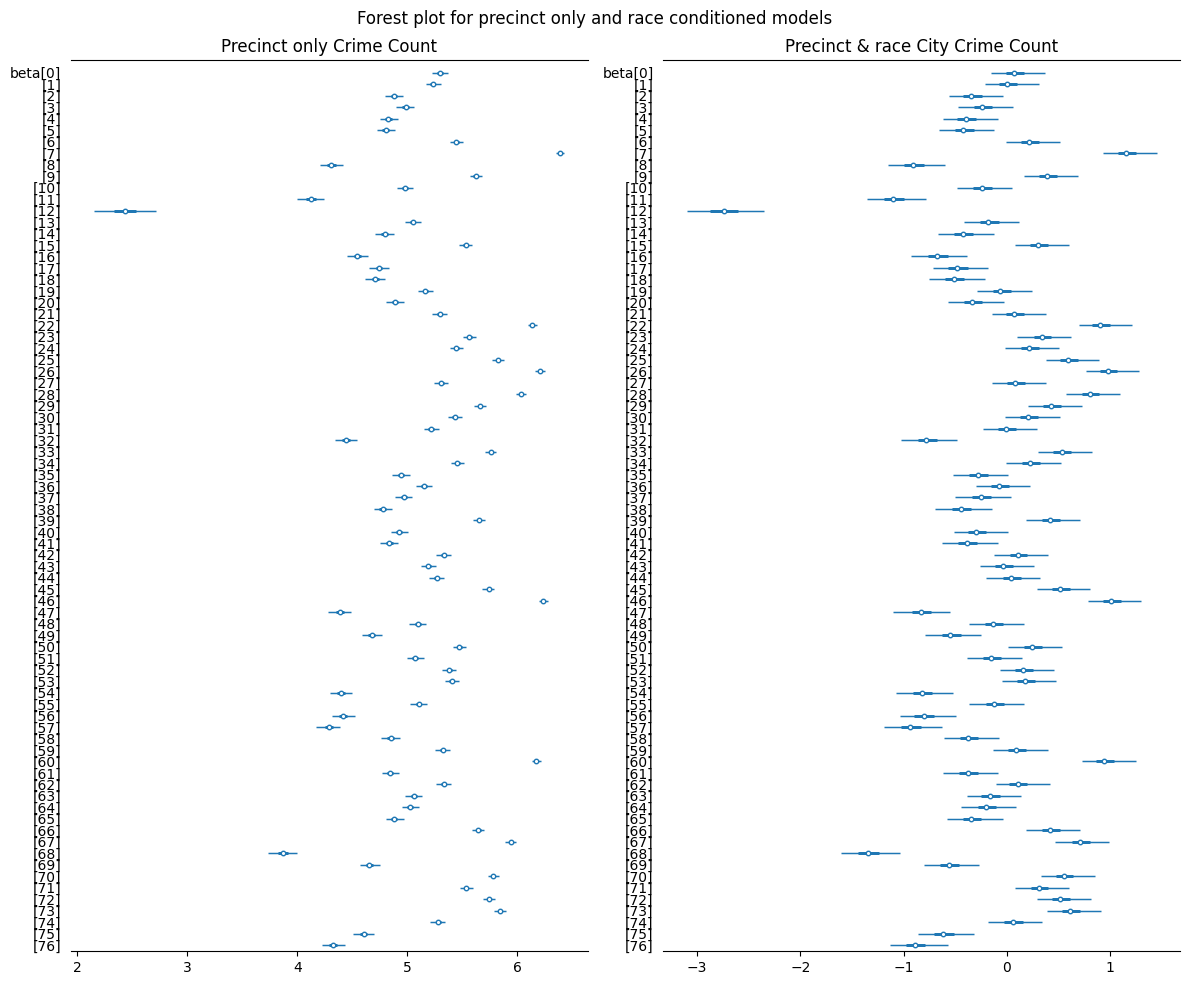

In [31]:
_, ax = plt.subplots(1, 2, figsize=(12, 10))

az.plot_forest(precinct_count_trace, combined=True, var_names=["beta"], ax=ax[0], textsize=10)
ax[0].set_title("Precinct only Crime Count")
az.plot_forest(precinct_race_count_trace, combined=True, var_names=["beta"], ax=ax[1], textsize=10)
ax[1].set_title("Precinct & race City Crime Count")
plt.suptitle("Forest plot for precinct only and race conditioned models")
plt.tight_layout()

## Debiasing

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_enc)
X_enc_scaled = scaler.transform(X_enc)
# Transform scaled array back to DataFrame
Xs_df = pd.DataFrame(X_enc_scaled, index=X_enc.index, columns=X_enc.columns)

# Now Xs_train_df is your scaled DataFrame with the original indexi
# print(Xs_df)
n_features = Xs_df.shape[1]

Xs_p = Xs_df.iloc[:, -4:]
Xs_np = Xs_df.iloc[:, :-4]

In [33]:
from scipy.linalg import orth

def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np.apply(lambda X: X - X.dot(orthbasis).dot(orthbasis.T))

    # Return debiased nonprotected features
    return Xs_np_debiased

features_np_debiased = debias_features(Xs_np, Xs_p)
X_debiased = pd.concat([features_np_debiased, Xs_p], axis=1)

In [34]:
with pm.Model() as debiased_crime_model:
    beta = pm.Normal('beta', mu=0, sigma=0.5, shape = len(X_debiased.columns) - 4)
    eta = pm.Normal('eta', mu=5, sigma=1.5, shape=2)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(pm.math.dot(X_debiased.iloc[:,:-4], beta) + pm.math.dot(X_debiased.iloc[:,-4:-2], eta)))
    
    crime = pm.Poisson('crime', lambda_, observed=y)

In [36]:
with debiased_crime_model:
    if device == "gpu":
        debiased_crime_trace = pm.sample(2000, tune=2000, return_inferencedata=True, cores=4, idata_kwargs=dict(log_likelihood=True), nuts_sampler="numpyro")
    else:
        debiased_crime_trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs=dict(log_likelihood=True))

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4000/4000 [11:59<00:00,  5.56it/s, 255 steps of size 2.88e-03. acc. prob=0.93] 
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [37]:
az.summary(debiased_crime_trace, var_names=["beta", "eta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.569,0.057,0.473,0.672,0.026,0.020,5.0,17.0,2.25
beta[1],0.561,0.057,0.467,0.664,0.026,0.020,5.0,17.0,2.24
beta[2],0.517,0.057,0.420,0.620,0.026,0.020,5.0,17.0,2.24
beta[3],0.530,0.057,0.434,0.633,0.026,0.020,5.0,17.0,2.23
beta[4],0.509,0.057,0.414,0.614,0.026,0.020,5.0,17.0,2.24
...,...,...,...,...,...,...,...,...,...
beta[74],0.567,0.057,0.473,0.673,0.026,0.020,5.0,17.0,2.25
beta[75],0.480,0.058,0.382,0.583,0.026,0.020,5.0,17.0,2.22
beta[76],0.441,0.058,0.346,0.549,0.026,0.020,5.0,16.0,2.21
eta[0],5.058,1.038,3.118,6.988,0.073,0.052,203.0,458.0,1.00


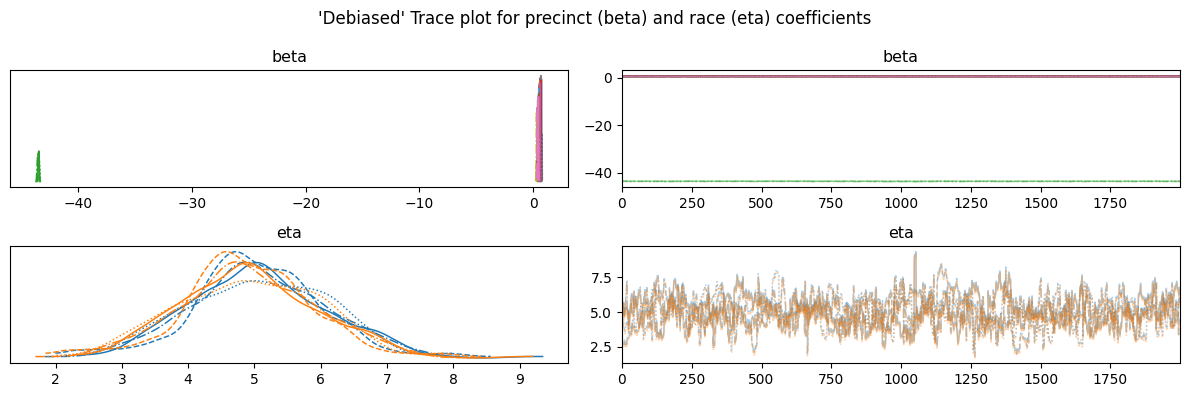

In [38]:
az.plot_trace(debiased_crime_trace, var_names=["beta", "eta"])
plt.suptitle("'Debiased' Trace plot for precinct (beta) and race (eta) coefficients")
plt.tight_layout()

Text(0.5, 1.0, 'Precinct & race City Crime Count')

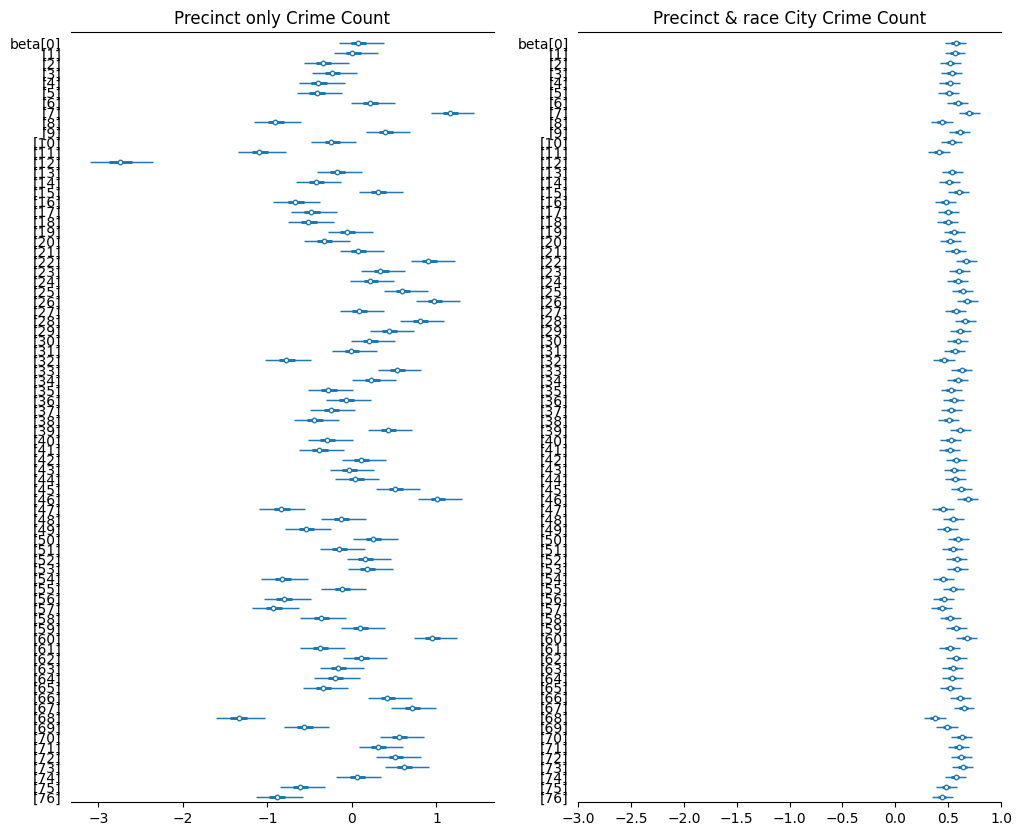

In [39]:
_, ax = plt.subplots(1, 2, figsize=(12, 10))

az.plot_forest(precinct_race_count_trace, combined=True, var_names=["beta"], ax=ax[0], textsize=10)
ax[0].set_title("Precinct only Crime Count")
az.plot_forest(debiased_crime_trace, combined=True, var_names=["beta"], ax=ax[1], textsize=10)
ax[1].set_xlim(-3, 1)
ax[1].set_title("Precinct & race City Crime Count")
